**A Twitter Sentimental Analyser** 
```c++
 __author__  =  'Strauss'
 __project__ =  'Machine Learning Proof of Concepts'
 __date__    =  '19/10/2020 01:51:02 (initial)'
```

In [168]:
import pandas as pd
import numpy as np
import pickle
import time
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer
import re
import string
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE 

#### Methods

In [53]:
def plot_confusion_matrix(cm, classes,normalize=False,cmap=plt.cm.Blues):
  title='Confusion Matrix Sentimental Analysis'
  try:
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True values')
    plt.xlabel('Predicted values')
    plt.tight_layout()
  except Exception as err:
    print('Erro ao plotar grafico: {0}'.format(err))

In [83]:
def clear_twitter_text(tweet):
    tweet = re.sub(r"http\S+", "", tweet).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (tweet)

#### Tokenizers

In [40]:
nltk.download('stopwords')
nltk.download('rslp')

stop_words = stopwords.words('portuguese')
stop_words.remove('não')

tkn = RegexpTokenizer(r'\w+')
tw_tkn = TweetTokenizer()

[nltk_data] Downloading package stopwords to /home/oak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/oak/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


#### Environment Configurations

In [93]:
pth = '/media/oak/4D38-34DE1/DATA/social_media/twitter/'
drw_nm = 'drw_twitties_mg.csv'
x_nm = 'texto'
y_nm = 'classe_sentimento'
random_state = 1612

#### Data Clean

In [94]:
drw = pd.read_csv(pth + drw_nm, sep=',')
drw = drw[['Text','Classificacao']]
dcl = drw.rename(columns={'Text': x_nm , 'Classificacao': y_nm})
dcl = dcl[pd.notnull(dcl[x_nm])]
dcl.drop_duplicates([x_nm], inplace=True)
dcl[x_nm] = dcl[x_nm].apply(clear_twitter_text)
dcl.shape

(5765, 2)

In [85]:
dcl.head(5)

,texto,classe_sentimento
0,���⛪ @ catedral de santo antônio governador v...,Neutro
1,"� @ governador valadares, minas gerais",Neutro
2,"�� @ governador valadares, minas gerais",Neutro
3,���,Neutro
4,��� psol vai questionar aumento de vereadores ...,Negativo


#### Data Analysis

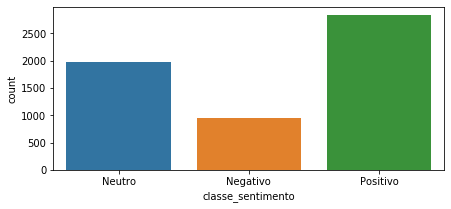

In [95]:
plt.figure(figsize=(7,3))
sb.countplot(x = y_nm, data = dcl)

In [96]:
dcl[y_nm].value_counts()

Positivo    2840
Neutro      1974
Negativo     951
Name: classe_sentimento, dtype: int64

In [102]:
dcl['tokens'] = dcl[x_nm].apply(tw_tkn.tokenize)
n_token = [word for tokens in dcl["tokens"] for word in tokens]
n_setence = [len(tokens) for tokens in dcl["tokens"]]
vocab = sorted(list(set(n_token)))
print('Vocabulario:{0}'.format(len(vocab)))
print('Registros:{0}'.format(len(n_setence)))
print('Tokens:{0}'.format(len(n_token)))

Vocabulario:7414
Registros:5765
Tokens:84465


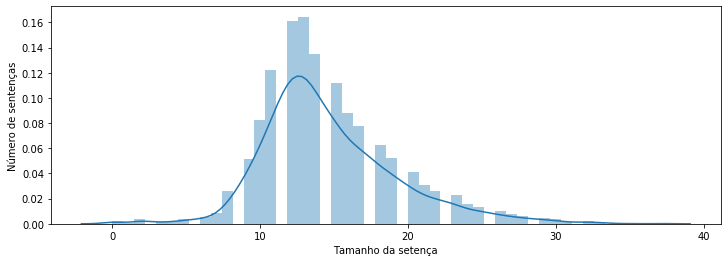

In [98]:
fig = plt.figure(figsize=(12, 4)) 
plt.xlabel('Tamanho da setença')
plt.ylabel('Número de sentenças')
sb.distplot(n_setence)

#### Vectorization

In [194]:
vec_tf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=1, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2),
                        stop_words=stopwords.words('portuguese'),
                        tokenizer=tweet_tokenizer.tokenize)

features_vec = vec_tf.fit_transform(dcl[x_nm])
Y = dcl[y_nm]
features_vec.shape

(5765, 25559)

In [195]:
n = 3000
ch2 = SelectKBest(score_func=chi2, k=n)
features_ch2_vec = ch2.fit_transform(features_vec, Y)
features_ch2_vec.shape

(5765, 3000)

#### Cross Validation

In [196]:
X_train,x_test,Y_train,y_test = train_test_split(features_ch2_vec,Y,shuffle=True,random_state = random_state)
X_train

<4323x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 57383 stored elements in Compressed Sparse Row format>

#### Data Sampling

In [197]:
samp_smote = SMOTE(random_state = random_state) 
X_train_samp, Y_train_samp = samp_smote.fit_sample(X_train,Y_train) 
x_teste_samp, y_test_samp = samp_smote.fit_sample(x_test,y_test) 

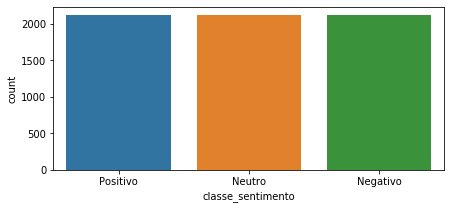

In [198]:
plt.figure(figsize=(7,3))
sb.countplot(x = y_nm, data = Y_train_samp.to_frame())

#### Models Evaluation

In [154]:
k_fold = 5
models      = []
results     = []
names       = []
vectorizers = []
models.append(('OneVsRest',OneVsRestClassifier(LinearSVC(random_state=random_state)))) 
models.append(('OneVsOne', OneVsOneClassifier(LinearSVC(random_state=random_state)))) 
models.append(('NB',       MultinomialNB())) 
models.append(('LR',       LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=random_state)))
models.append(('RandomForest', RandomForestClassifier(n_estimators=10, random_state=random_state))) 
models.append(('ExtraTrees', ExtraTreesClassifier(n_estimators=10, random_state=random_state)))
models.append(('sgd', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=random_state, max_iter=5, tol=None)))
models.append(('svm',  (svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))))
#models.append(('AdaBoost', AdaBoostClassifier(random_state=random_state))) 
#models.append(('GradientBoosting', GradientBoostingClassifier(random_state=random_state))) 

#### Training

In [155]:
print('Inicio do Treino...')
k_fold=5
start=time.time() 
for nme_model, model in models:
  model.fit(X_train_samp,Y_train_samp)
  metrics_k_fold = cross_val_score(model, X_train_samp, Y_train_samp, cv=k_fold, scoring='f1_macro')   
  elapsed = time.time() - start
  results.append(metrics_k_fold)
  names.append(nme_model)
  print('Modelo:{0} Média :{1}  STD:{2} Tempo execucao:{3}'.format(nme_model.ljust(16,' '),round(metrics_k_fold.mean(),5),round(metrics_k_fold.std(),5),round(elapsed,4)))  
print('Fim do Treino')
print('Tempo gasto:{0}'.format(time.time() - start))  

Inicio do Treino...
Modelo:OneVsRest        Média :0.95153  STD:0.00966 Tempo execucao:0.49
Modelo:OneVsOne         Média :0.94895  STD:0.01059 Tempo execucao:0.7974
Modelo:NB               Média :0.93164  STD:0.00255 Tempo execucao:0.9487
Modelo:LR               Média :0.95825  STD:0.0107 Tempo execucao:5.453
Modelo:RandomForest     Média :0.95829  STD:0.00878 Tempo execucao:6.7349
Modelo:ExtraTrees       Média :0.96484  STD:0.00846 Tempo execucao:8.3988
Modelo:sgd              Média :0.90863  STD:0.00876 Tempo execucao:8.539
Modelo:svm              Média :0.92346  STD:0.00883 Tempo execucao:16.2967
Fim do Treino
Tempo gasto:16.29723882675171


#### Test

In [156]:
metric=[]
start = time.time()
for name, model in models:
  yp = model.predict(x_teste_samp)
  score = round(f1_score(y_test_samp, yp, pos_label=1, average='macro'),4)  
  elapsed = time.time() - start
  metric.append(score)
  print('Modelo:{0}  Score:{1}  Tempo execucao:{2}'.format(name.ljust(20,' '),round(score,5),round(elapsed,4)))

Modelo:OneVsRest             Score:0.9392  Tempo execucao:0.0119
Modelo:OneVsOne              Score:0.938  Tempo execucao:0.0278
Modelo:NB                    Score:0.9205  Tempo execucao:0.0386
Modelo:LR                    Score:0.9409  Tempo execucao:0.0691
Modelo:RandomForest          Score:0.9354  Tempo execucao:0.0969
Modelo:ExtraTrees            Score:0.9266  Tempo execucao:0.1182
Modelo:sgd                   Score:0.8923  Tempo execucao:0.1274
Modelo:svm                   Score:0.9171  Tempo execucao:0.5824


In [199]:
model_win = models[3][1]
model_win

LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=1612, solver='newton-cg')

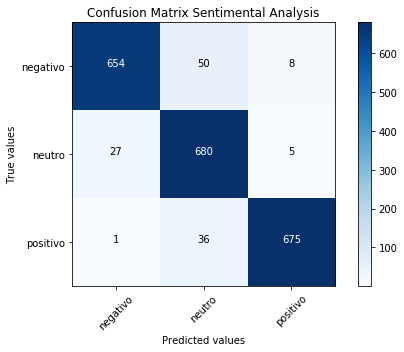

In [200]:
yp = model_win.predict(x_teste_samp)
cm=confusion_matrix(y_test_samp, yp)
np.set_printoptions(precision=2)
plt.figure(figsize=(7,5))
plot_confusion_matrix(cm, classes=['negativo', 'neutro', 'positivo'])

#### Save steps pipeline models to deploy

In [204]:
model_nm = "c1_classifier.pkl"  
vec_nm   = 'c1_vect.pkl'
ch2_nm   = 'c1_ch2.pkl'
samp_nm  = 'c1_sample.pkl'

with open(model_nm, 'wb') as file:  
  pickle.dump(model_win, file)

with open(vec_nm, 'wb') as file:  
  pickle.dump(vec_tf, file)

with open(ch2_nm, 'wb') as file:  
  pickle.dump(ch2, file)

with open(samp_nm, 'wb') as file:  
  pickle.dump(samp_smote, file)

#### Running the model

In [207]:
with open(model_nm, 'rb') as file:  
    model = pickle.load(file)

with open(vec_nm, 'rb') as file:  
    vec = pickle.load(file)    

with open(ch2_nm, 'rb') as file:  
    ch2 = pickle.load(file)    

with open(samp_nm, 'rb') as file:  
    sample = pickle.load(file)

In [178]:
model

LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=1612, solver='newton-cg')

In [173]:
vec

TfidfVectorizer(encoding='latin-1', ngram_range=(1, 2),
                stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                            'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                            'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                            'ao', 'ele', 'das', 'à', 'seu', 'sua', ...],
                sublinear_tf=True,
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f4bb7d5e828>>)

In [174]:
ch2

SelectKBest(k=3000, score_func=<function chi2 at 0x7f4bc39b1730>)

In [208]:
sample

SMOTE(random_state=1612)

In [222]:
drw = pd.read_csv(pth + drw_nm, sep=',')
drw = drw[['Text','Classificacao']]
dcl = drw.rename(columns={'Text': x_nm , 'Classificacao': y_nm})
dcl = dcl[pd.notnull(dcl[x_nm])]
dcl.drop_duplicates([x_nm], inplace=True)
dcl[x_nm] = dcl[x_nm].apply(clear_twitter_text)
dcl.shape

(5765, 2)

In [223]:
features_vec = vec.transform(dcl[x_nm])

In [230]:
features_ch2_vec = ch2.transform(features_vec)
features_ch2_vec.shape

(5765, 3000)

In [231]:
X = features_ch2_vec
Y = dcl[y_nm]
yp = model.predict(X)
dcl['classe_yp'] = yp

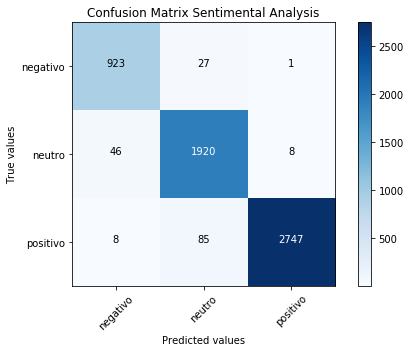

In [232]:
yp = model.predict(features_ch2_vec)
cm=confusion_matrix(dcl[y_nm], yp)
np.set_printoptions(precision=2)
plt.figure(figsize=(7,5))
plot_confusion_matrix(cm, classes=['negativo', 'neutro', 'positivo'])